# Feature Extraction

In [15]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
import dataset



In [30]:
def visualize_images(images):
    # Give this function any number of images or depth maps
    # and it will display them in a grid.

    n = len(images)
    # Calculate number of rows and columns
    width = math.ceil(math.sqrt(n))
    height = math.ceil(n / width)
    plt.figure(figsize=(17.5, 5))
    fig, axes = plt.subplots(height, width)
    plt.subplots_adjust(wspace=0, hspace=0)
    if n == 1:
        axes.imshow(images[0])
        axes.axis('off')
        return
    for i, ax in enumerate(axes.flatten()):
        if(i<n): 
            # Display image
            image = images[i]
            image = np.transpose(image, (1, 2, 0))
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide axis if no image
            ax.axis('off')
    fig.set_size_inches(17.454545*width, 5*height)
    plt.show()

def load_image(file_path):
    return Image.open(file_path)

def load_depth(file_path):
    return Image.open(file_path)

class MinMaxNormalize(object):
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

<Figure size 1750x500 with 0 Axes>

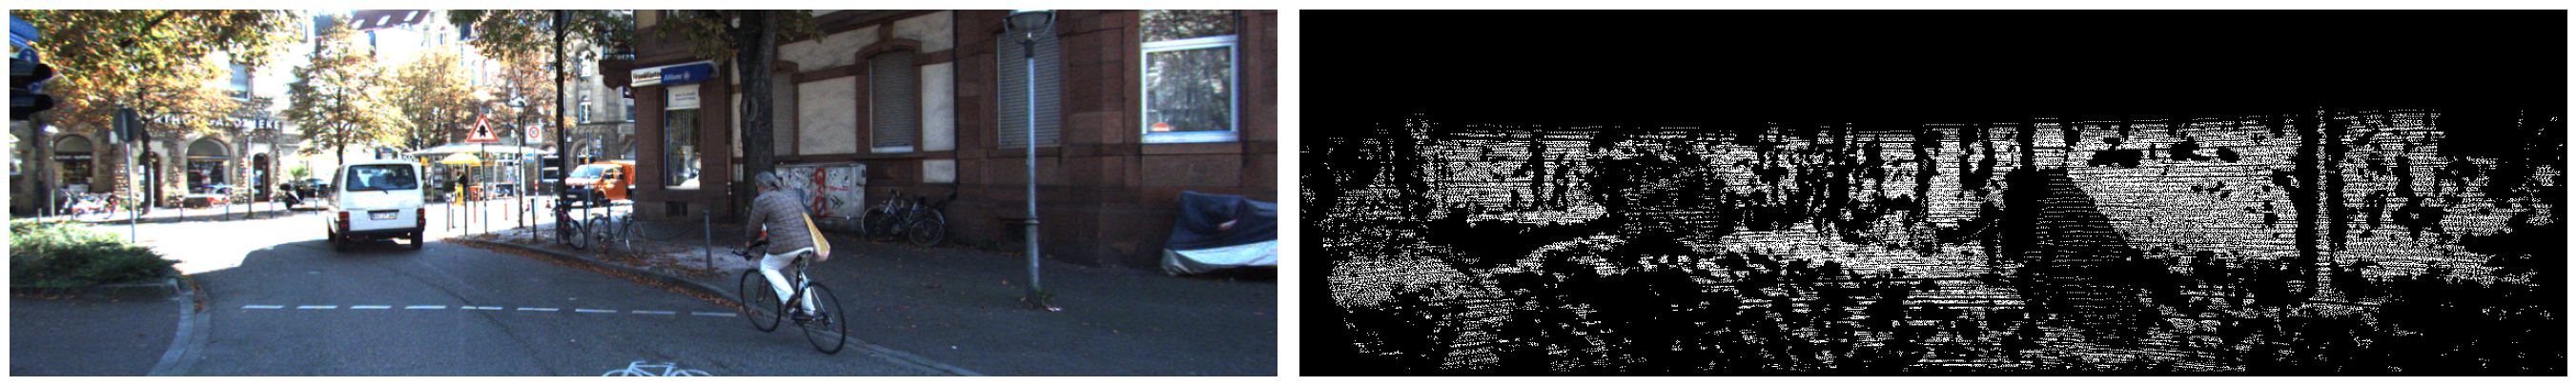

In [17]:
# Set Directories
base_dir = 'dataset'
image_dir = os.path.join(base_dir, 'image')
depth_dir = os.path.join(base_dir, 'groundtruth_depth')

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
depth_files = sorted([os.path.join(depth_dir, file) for file in os.listdir(depth_dir)])

# Ensure that the lists are aligned and have the same length
assert len(image_files) == len(depth_files), "The number of images and depth maps should be the same"

# Load the data into variables
images = [load_image(file) for file in image_files]
depth_maps = [load_depth(file) for file in depth_files]
data = list(zip(images, depth_maps))

# Visualize a sample from the dataset
visualize_images([images[30], depth_maps[30]])

In [28]:
def display_two_images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots
    
    # Display the first image on the left subplot
    axes[0].imshow(image1)
    # axes[0].set_title('Image 1')
    
    # Display the second image on the right subplot
    axes[1].imshow(image2)
    # axes[1].set_title('Image 2')
    
    # Hide axis ticks and labels for better visualization
    for ax in axes:
        ax.axis('off')
    
    plt.show()

<Figure size 1750x500 with 0 Axes>

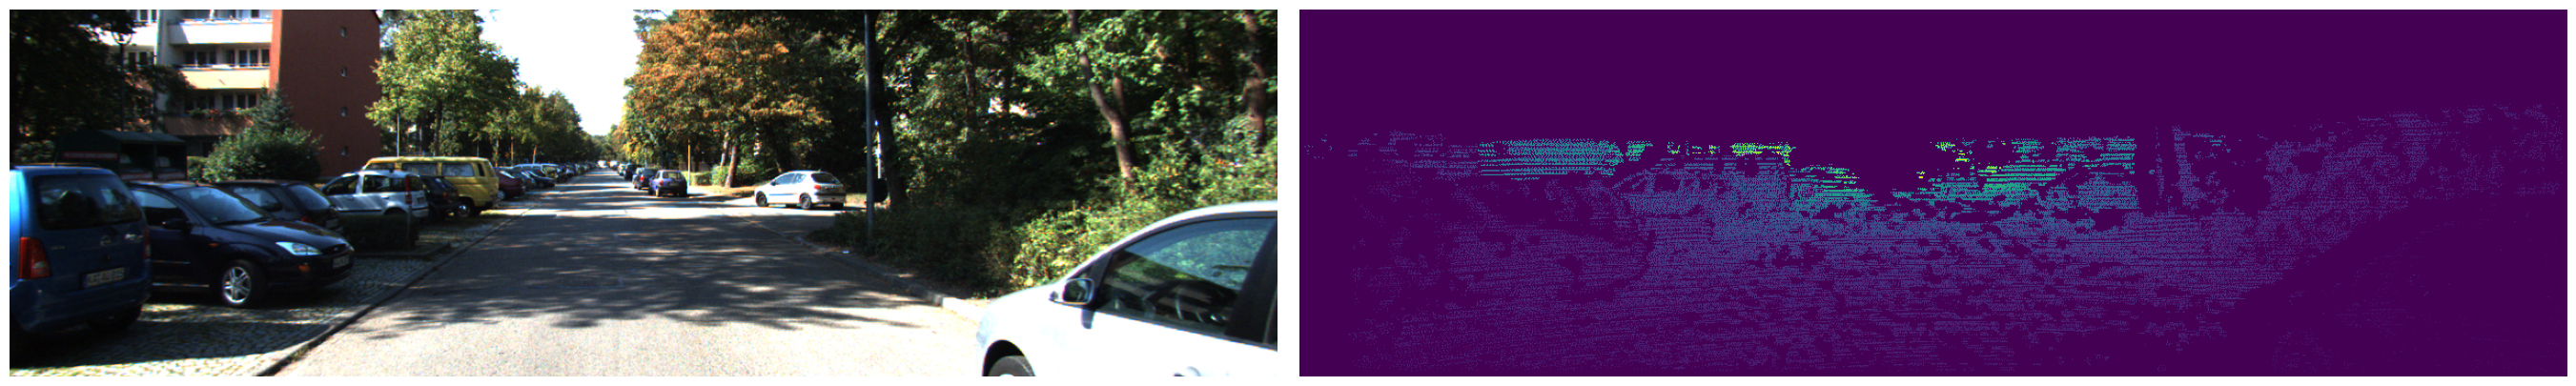

In [32]:
# define image transformation
transform = transforms.Compose([
    transforms.Resize((352, 1216)),
    transforms.ToTensor(),
    MinMaxNormalize()
])

train, test = train_test_split(data, test_size=0.20, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)

train_dataset = dataset.DepthDataset(train, transform)
val_dataset = dataset.DepthDataset(val, transform)
test_dataset = dataset.DepthDataset(test, transform)

batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images_batch1, labels_batch1 = next(dataiter)

# Print the first two examples
visualize_images([images_batch1[0], labels_batch1[0]])


In [33]:

def load_model(removed_layers = 1):
    # Load Pre-Trained Model
    model = models.resnet18(pretrained=True)
    #model = model.to("cpu")
    #remove final connected layers from model
    #model.fc = nn.Identity()
    model = torch.nn.Sequential(*list(model.children())[:-removed_layers])
    return model

In [35]:
# Function to extract features
def extract_features(dataloader, model = load_model(1)):
    features = []
    with torch.no_grad(): #Disables gradient calcullation
        for inputs, _ in dataloader:
            outputs = model(inputs)
            features.append(outputs.flatten(1))
    return torch.cat(features)

features = extract_features(trainloader, load_model(1))
features.shape

C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

# Reduce Dimensionality with LLE
1 512
2 214016
3 428032

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
#Hyperparamaters!
n_components = 150
n_neighbors = 25
lle = LocallyLinearEmbedding(n_components = n_components, n_neighbors = n_neighbors, method='standard')
features_lle = lle.fit_transform(features)
features.shape, features_lle.shape

(torch.Size([2000, 512]), (2000, 150))